# Прогнозирование оттока клиентов телеком-оператора

Импорт библиотек

In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

import lightgbm
import catboost

import optuna

import warnings

In [2]:
plt.rcParams['figure.figsize'] = (12,6)

## Исследовательский анализ данных

### Обзор файлов с данными

In [3]:
try:
    df_contract = pd.read_csv('/home/mike/repos/contract.csv')
except FileNotFoundError:
    df_contract = pd.read_csv('/datasets/final_provider/contract.csv')
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
try:
    df_internet = pd.read_csv('/home/mike/repos/internet.csv')
except FileNotFoundError:
    df_internet = pd.read_csv('/datasets/final_provider/internet.csv')
df_internet.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [5]:
try:
    df_personal = pd.read_csv('/home/mike/repos/personal.csv')
except FileNotFoundError:
    df_personal = pd.read_csv('/datasets/final_provider/personal.csv')
df_personal.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [6]:
try:
    df_phone = pd.read_csv('/home/mike/repos/phone.csv')
except FileNotFoundError:
    df_phone = pd.read_csv('/datasets/final_provider/phone.csv')
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


### Обзор данных и первичная предобработка

Изучение данных с помощью методов:
* df.info() - общее количество данных, проверка наименований столбцов (переименование при необходимости), проверка на соответствие типов данных (изменение типов данных при необходимости), наличие пропущенных значений (анализ возможных стратегий избавления от пропусков: удаление объектов с пропущенными значениями, заполнение нулями, заполнение медианой и т.п.).

In [7]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


`BeginDate` необходимо перевести в тип date, `EndDate` - из этого столбца делаем целевой признак (если указана дата, то абонент ушел, ставим значение 1, в противном случае 0), `TotalCharges` необходимо перевести в тип float64

In [8]:
def is_churn(x):
    if x == 'No':
        return 0
    else: return 1

In [9]:
df_contract.TotalCharges = df_contract.TotalCharges.str.replace(' ', '0').astype(float)
df_contract.BeginDate = pd.to_datetime(df_contract.BeginDate)
df_contract['Churn'] = df_contract.EndDate.apply(is_churn)

In [10]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   float64       
 7   TotalCharges      7043 non-null   float64       
 8   Churn             7043 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 495.3+ KB


Все преобразования выполнены

In [11]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


Преобразования не нужны

In [12]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


Преобразования не нужны

In [13]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


Преобразования не нужны

* df.describe() - для числовых данных анализ рахмаха (обоснованность максимальных и минимальных значений и удаление объектов с ошибочными данными, квартильный анализ).

числовые данные есть только в датафрейме `df_contract`

In [14]:
df_contract[['MonthlyCharges','TotalCharges']].describe()

,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000
mean,64.761692,2279.734304
std,30.090047,2266.794470
min,18.250000,0.000000
25%,35.500000,398.550000
50%,70.350000,1394.550000
75%,89.850000,3786.600000
max,118.750000,8684.800000


Разброс `TotalCharges` значительно больше, чем `MonthlyCharges` - максимальное значение `MonthlyCharges` больше среднего примерно в 2 раза, а максимальное значение `TotalCharges` больше среднего почти в 4 раза. При этом медиана `MonthlyCharges` чуть больше среднего, а медиана `TotalCharges` значительно меньше среднего. То есть ежемесячные платежи абонентов не очень сильно отличаются друг от друга, а в накопленных платежах абонентов есть группа больших значений, которые увелививают разброс и смещают среднее вправо. Возможно, это группа "ветеранов", которые давно пользуются услугами оператора. Проверим эту гипотезу на графиках плотности распрееления.

* s.plot(kind='kde') - построение графиков плотности распределения для цифровых данных, оценка формы распределения.

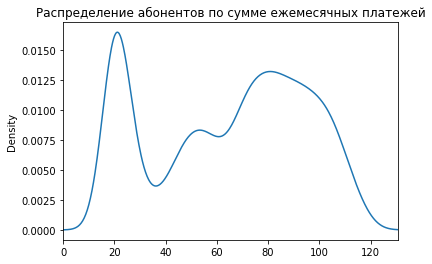

In [15]:
df_contract['MonthlyCharges'].plot(kind='kde', 
                                   title='Распределение абонентов по сумме ежемесячных платежей',
                                   xlim=(0, df_contract['MonthlyCharges'].max()*1.1)
                                   )
None

Большинство абонентов платят около 20 в месяц, при этом есть значительная группа абонентов, которые платят от 70 до 100 в месяц. Распределение очень сильно отличается от нормального.

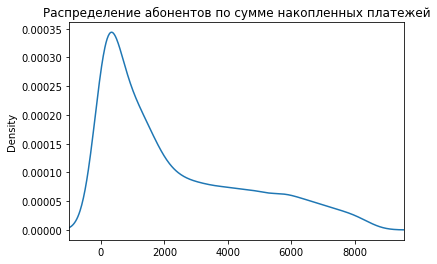

In [16]:
df_contract['TotalCharges'].plot(kind='kde', 
                                 title='Распределение абонентов по сумме накопленных платежей',
                                 xlim=(-1000, df_contract['TotalCharges'].max()*1.1)
                                   )
None

У большинства абонентов небольшая накопленная сумма платежей. Скорее всего они недавно пользуются услугами оператора. Распределение сильно отличается от нормального.


* s.value_counts() - для категориальных данных подсчет количества объектов в каждой категории (построение столбчатых диаграм для наглядности).

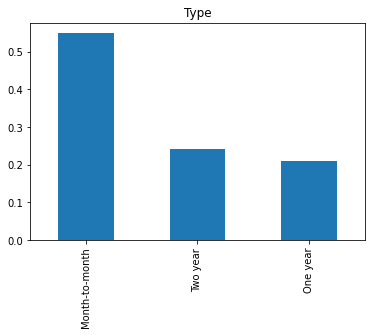

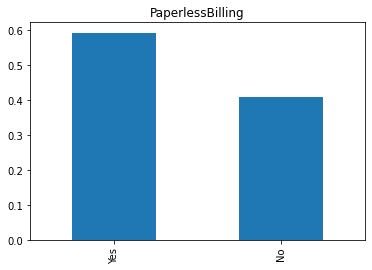

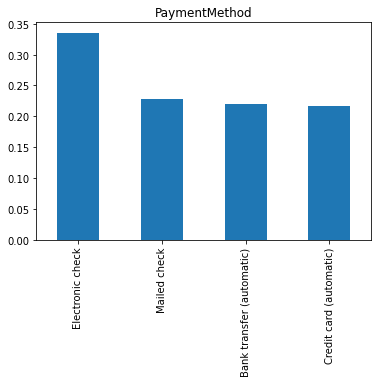

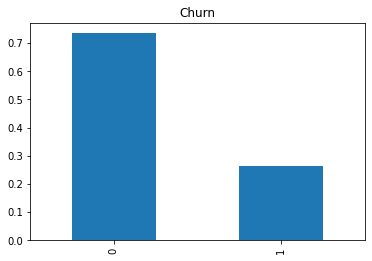

In [17]:
for column in ['Type', 'PaperlessBilling', 'PaymentMethod', 'Churn']:
    df_contract[column].value_counts(normalize=True).plot(kind='bar', title=column)
    plt.show()

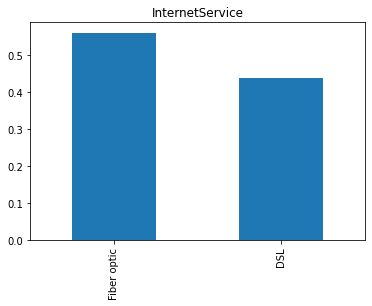

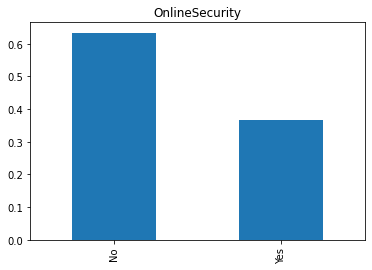

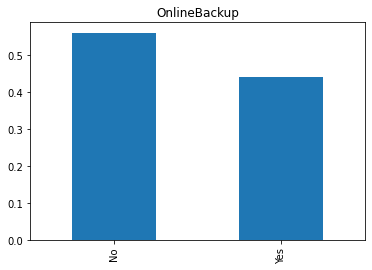

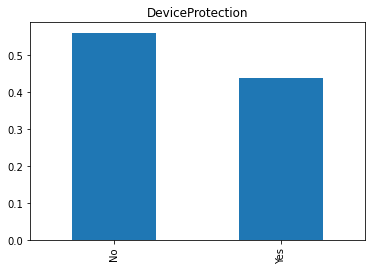

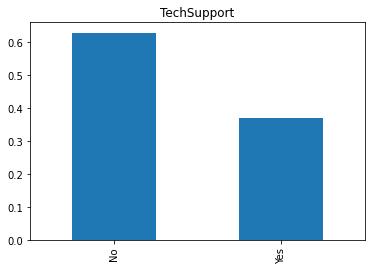

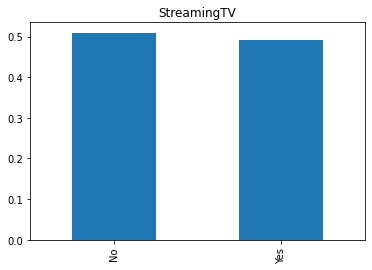

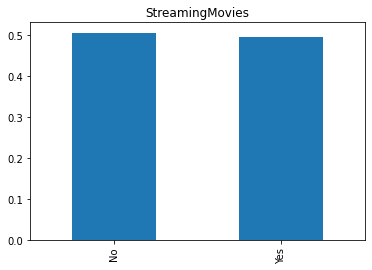

In [18]:
for column in df_internet.drop(columns='customerID').columns:
    df_internet[column].value_counts(normalize=True).plot(kind='bar', title=column)
    plt.show()

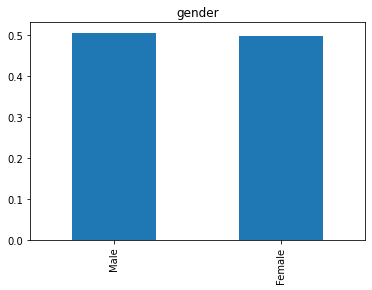

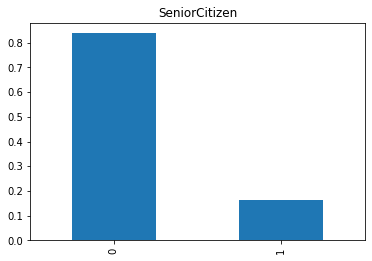

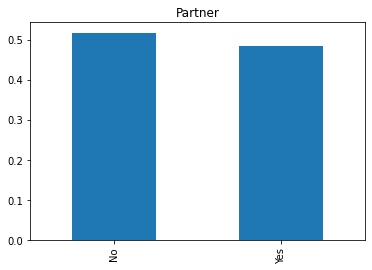

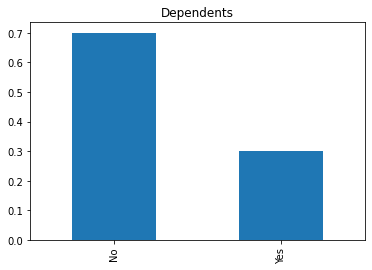

In [19]:
for column in df_personal.drop(columns='customerID').columns:
    df_personal[column].value_counts(normalize=True).plot(kind='bar', title=column)
    plt.show()

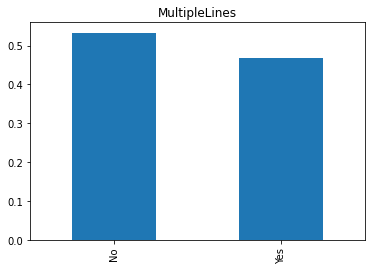

In [20]:
for column in df_phone.drop(columns='customerID').columns:
    df_phone[column].value_counts(normalize=True).plot(kind='bar', title=column)
    plt.show()

Присутствует дисбаланс классов. Необходимо это учесть при обучении моделей.
Значений в категориальных признаках достаточно для обучения (отсутствуют категории с очень маленьким количеством объектов)


Дополнительно обзор данных отдельно для оставшихся клиентов и ушедших для оценки наиболее значимых факторов (датафреймы объединяются по полю `customerID`).
В датафреймах `df_contract` и `df_personal` одинаковое количество строк. Очевидно, они содержат данные обо всех клиентах. В этом случае `customerID` в обоих датафреймах должны совпадать. Проверим это.

In [21]:
if len(df_personal['customerID'].unique()) == len(df_contract['customerID'].unique()):
    for contract in df_contract['customerID'].unique():
        if contract not in df_personal['customerID'].unique():
            print('Найдено отличие')
    print('Отличий не найдено')

Отличий не найдено


Можно объединять датафреймы `df_contract` и `df_personal` по `customerID`

In [22]:
print('df_contract shape', df_contract.shape)
print('df_personal shape', df_personal.shape)
df_clients = df_contract.merge(df_personal, on='customerID')
print('df_clients shape', df_clients.shape)

df_contract shape (7043, 9)
df_personal shape (7043, 5)
df_clients shape (7043, 13)


In [23]:
print(df_contract.columns)
print(df_personal.columns)
print(df_clients.columns)

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')
Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')
Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents'],
      dtype='object')


Количество строк в итоговом датафрейме совпадает с исходными. Количество столбцов совпадает за исключением `customerID` - он не дублируется

### Визуальный анализ данных

* Построение sns.pairplot() для оценки линейной корреляции

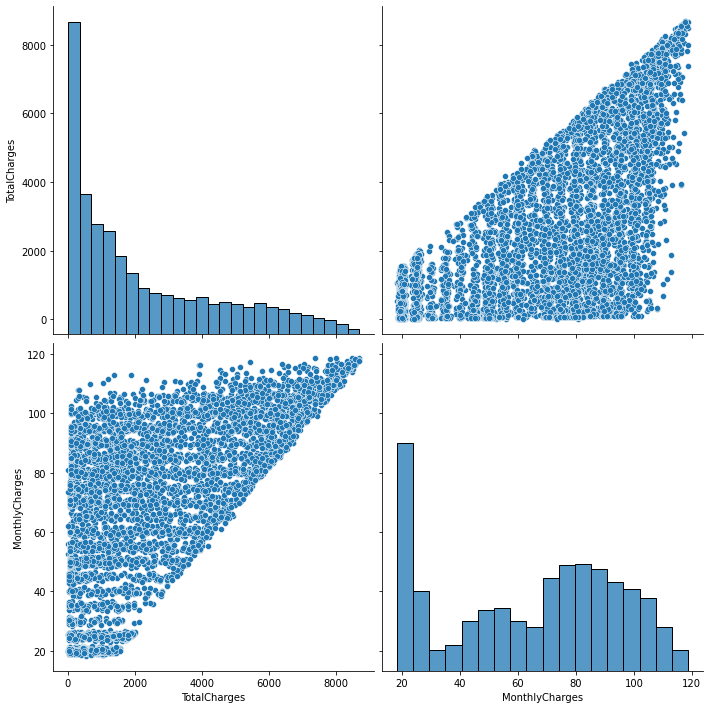

In [24]:
sns.pairplot(df_contract[['TotalCharges', 'MonthlyCharges']], height=5)
None

Среди абонентов с небольшими ежемесячными платежами остуствуют абоенты с большой накопленной суммой платежей. То есть мало платящие абоненты не пользуются услугами оператора очен долго

* Построение boxplot() для оценки количества выбросов (полтора межквартильных интервала)

<AxesSubplot:>

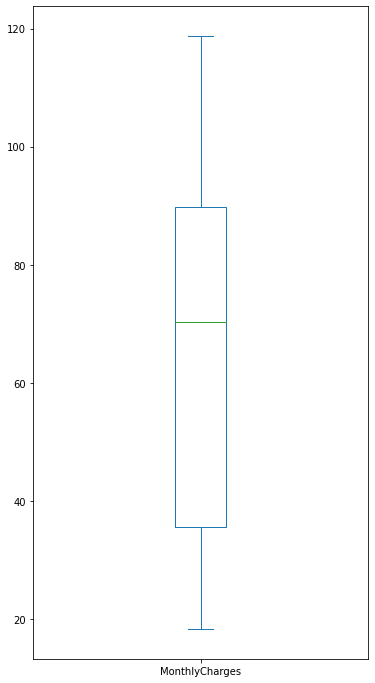

In [25]:
df_contract['MonthlyCharges'].plot(kind='box', figsize=(6,12))

<AxesSubplot:>

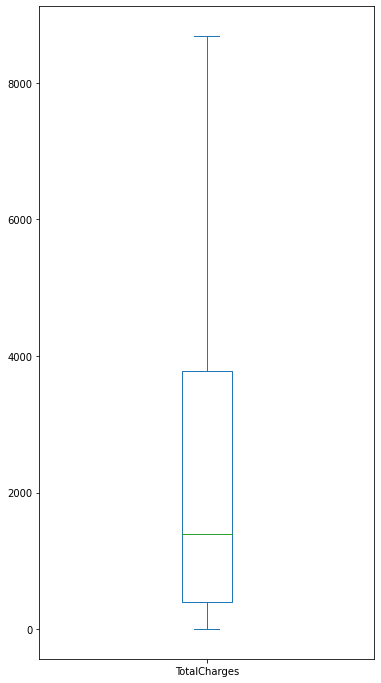

In [26]:
df_contract['TotalCharges'].plot(kind='box', figsize=(6,12))

* Построение матрицы корреляции числовых признаков для оценки наиболее значимых факторов и мультиколлинеарности

In [27]:
df_contract[['TotalCharges', 'MonthlyCharges']].corr()

,TotalCharges,MonthlyCharges
TotalCharges,1.000000,0.651174
MonthlyCharges,0.651174,1.000000


***Выводы:***
1. Пропущенные значения отсуствуют, ничего заполнять не нужно.
2. Типы данных исправлены.
3. Создан целевой признак `Churn` из столбца `EndDate` (No = 0, дата = 1).

### Предобработка данных

Объединим все датафреймы в один по `customerID`

In [28]:
df_cb = df_clients.merge(df_internet, on='customerID', how='left')
df_cb = df_cb.merge(df_phone, on='customerID', how='left')
df_cb.shape

(7043, 21)

In [29]:
df_cb

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,...,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0,Male,...,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,...,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,...,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,...,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.50,0,Male,...,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.90,0,Female,...,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,0,Female,...,Yes,Yes,DSL,Yes,No,No,No,No,No,NaN
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.60,1,Male,...,Yes,No,Fiber optic,No,No,No,No,No,No,Yes


* Кодирование категориальных признаков (с небольшим количеством значений - OneHotEncoding, с большим количеством значений - OrdinalEncoding). 

Все признаки с небольшим количеством значений: максимум 4, почти все кроме двух - только 2 значения. Поэтому используем OneHotEncoding.

In [30]:
df_cb = df_cb.drop(columns=['BeginDate', 'EndDate'])
df_cb.set_index('customerID', inplace=True)
df_cb.fillna(0, inplace=True)
df_ohe = pd.get_dummies(df_cb.drop(columns=['Churn']), drop_first=True)
df = pd.concat([df_cb[['Churn']], df_ohe],
                ignore_index=True, axis=1
)
df.columns = ['Churn'] + list(df_ohe.columns)
df

,Churn,MonthlyCharges,TotalCharges,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,...,DeviceProtection_No,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,MultipleLines_No,MultipleLines_Yes
customerID,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,29.85,29.85,0,0,0,1,0,1,0,...,1,0,1,0,1,0,1,0,0,0
5575-GNVDE,0,56.95,1889.50,0,1,0,0,0,0,1,...,0,1,1,0,1,0,1,0,1,0
3668-QPYBK,1,53.85,108.15,0,0,0,1,0,0,1,...,1,0,1,0,1,0,1,0,1,0
7795-CFOCW,0,42.30,1840.75,0,1,0,0,0,0,0,...,0,1,0,1,1,0,1,0,0,0
9237-HQITU,1,70.70,151.65,0,0,0,1,0,1,0,...,1,0,1,0,1,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,0,84.80,1990.50,0,1,0,1,0,0,1,...,0,1,0,1,0,1,0,1,0,1
2234-XADUH,0,103.20,7362.90,0,1,0,1,1,0,0,...,0,1,1,0,0,1,0,1,0,1
4801-JZAZL,0,29.60,346.45,0,0,0,1,0,1,0,...,1,0,1,0,1,0,1,0,0,0


На этом этапе оставляем датафрей с некодированными категориальными данными, который будем использовать для работы с CatBoost.

In [31]:
df_cb

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,0
5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,0
9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,One year,Yes,Mailed check,84.80,1990.50,0,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
2234-XADUH,One year,Yes,Credit card (automatic),103.20,7362.90,0,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
4801-JZAZL,Month-to-month,Yes,Electronic check,29.60,346.45,0,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,0


* Разделение выборки на обучающую и тестовую (hold out)

In [32]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='Churn'), 
                                                    df['Churn'], 
                                                    test_size=0.25, 
                                                    random_state=0,
                                                    stratify=df['Churn']
                                                    )
X_cb_train, X_cb_test, y_cb_train, y_cb_test = train_test_split(df_cb.drop(columns='Churn'), 
                                                                df_cb['Churn'], 
                                                                test_size=0.25, 
                                                                random_state=0,
                                                                stratify=df_cb['Churn']
                                                                )
cat_features = list(df_cb.drop(columns=['MonthlyCharges','TotalCharges', 'Churn', 'SeniorCitizen']).columns)

In [33]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

(5282, 28)
(1761, 28)
(5282,)
(1761,)
0    0.73457
1    0.26543
Name: Churn, dtype: float64
0    0.73481
1    0.26519
Name: Churn, dtype: float64


## Построение моделей

### Построение моделей на исходном датасете

Построение LogisticRegression, kNN, RandomForest, LightGBM, CatBoost (на датасете без кодирования категориальных признаков). Выбор лучшей модели для дальнейшей тонкой настройки
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import lightgbm

In [47]:
models = {
    'LogisticRegression':LogisticRegression(random_state=0), 
    'kNN':KNeighborsClassifier(), 
    'RandomForest':RandomForestClassifier(random_state=0, class_weight='balanced'), 
    'LightGBM':lightgbm.LGBMClassifier(random_state=0, class_weight='balanced')
}

In [48]:
for model_name in models:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        cv_results = cross_validate(models[model_name], X_train, y_train, scoring='roc_auc', trturn_estimator=True)
    print(f'{model_name} ROC_AUC: {cv_results["test_score"].mean():.3f}')

LogisticRegression ROC_AUC: 0.835
kNN ROC_AUC: 0.746
RandomForest ROC_AUC: 0.818
LightGBM ROC_AUC: 0.835


In [85]:
cv_results = cross_validate(catboost.CatBoostClassifier(cat_features=cat_features, 
                                                        silent=True, random_state=0, 
                                                        auto_class_weights='SqrtBalanced'), 
                                                        X_cb_train, 
                                                        y_cb_train, 
                                                        scoring='roc_auc',
                                                        return_estimator=True)
print(f'CatBoostClassifier ROC_AUC: {cv_results["test_score"].mean():.3f}')

CatBoostClassifier ROC_AUC: 0.847


In [64]:
best_cvscore = cv_results['test_score'].max()
best_cvest = cv_results['estimator'][list(cv_results['test_score']).index(best_cvscore)]
best_cvest

In [68]:
cb_preds = best_cvest.predict_proba(X_cb_test)
#cb_preds
roc_auc_score(y_test, cb_preds[:,1])

0.8423972940502864

In [71]:
X_cb_test

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,
2782-LFZVW,Month-to-month,Yes,Mailed check,58.95,601.60,Female,0,No,No,DSL,No,No,No,No,No,Yes,Yes
0098-BOWSO,Month-to-month,Yes,Electronic check,19.40,529.80,Male,0,No,No,0,0,0,0,0,0,0,No
1293-BSEUN,Two year,Yes,Mailed check,20.70,1482.30,Female,0,Yes,Yes,0,0,0,0,0,0,0,No
4475-NVTLU,Two year,No,Electronic check,19.20,903.70,Male,0,Yes,Yes,0,0,0,0,0,0,0,No
1763-WQFUK,Month-to-month,Yes,Mailed check,50.50,147.75,Male,0,No,No,DSL,No,No,No,Yes,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106-HRLKZ,Two year,No,Mailed check,19.60,808.95,Male,0,Yes,Yes,0,0,0,0,0,0,0,No
1513-XNPPH,Month-to-month,Yes,Electronic check,89.40,1095.65,Female,0,No,No,Fiber optic,No,No,Yes,Yes,No,Yes,No
7145-FEJWU,Month-to-month,Yes,Electronic check,105.30,1275.65,Female,0,No,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes


In [77]:
cb_model = catboost.CatBoostClassifier(cat_features=cat_features,
                                        iterations=1000, 
                                        random_seed=0,
                                        auto_class_weights='SqrtBalanced')
cb_summary = cb_model.select_features(
    X_cb_train, y_cb_train,
    eval_set=(X_cb_test, y_cb_test),
    features_for_select='0-16',
    num_features_to_select=10,
    train_final_model=True,
    logging_level='Silent',
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [81]:
X_cb_test[cb_summary['selected_features_names']]

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,TechSupport,StreamingTV
customerID,,,,,,,,,,
2782-LFZVW,Month-to-month,Yes,Mailed check,58.95,601.60,DSL,No,No,No,No
0098-BOWSO,Month-to-month,Yes,Electronic check,19.40,529.80,0,0,0,0,0
1293-BSEUN,Two year,Yes,Mailed check,20.70,1482.30,0,0,0,0,0
4475-NVTLU,Two year,No,Electronic check,19.20,903.70,0,0,0,0,0
1763-WQFUK,Month-to-month,Yes,Mailed check,50.50,147.75,DSL,No,No,Yes,No
...,...,...,...,...,...,...,...,...,...,...
1106-HRLKZ,Two year,No,Mailed check,19.60,808.95,0,0,0,0,0
1513-XNPPH,Month-to-month,Yes,Electronic check,89.40,1095.65,Fiber optic,No,No,Yes,No
7145-FEJWU,Month-to-month,Yes,Electronic check,105.30,1275.65,Fiber optic,No,Yes,No,Yes


In [83]:
cb_model = catboost.CatBoostClassifier(cat_features=['Type','PaperlessBilling','PaymentMethod','InternetService','OnlineSecurity','OnlineBackup','TechSupport','StreamingTV'], 
                                                        silent=True, random_state=0, 
                                                        auto_class_weights='SqrtBalanced')

cb_model.fit(X_cb_train[cb_summary['selected_features_names']], y_cb_train)
cb_preds = cb_model.predict_proba(X_cb_test[cb_summary['selected_features_names']])
roc_auc_score(y_test, cb_preds[:,1])

0.8455042048790496

### Перобразование существующих и создание дополнительных признаков

* Масштабирование числовых признаков
* Логарифмирование числовых признаков с распределением отличным от нормального
* Добавление столбцов для выбросов (полтора межквартильных интервала, три межквартильных интервала)
* Добавление признаков кластеризацией и поиском аномалий
* Определение наиболее важных признаков, перестроение моделей только на них, чтобы избавиться от возможного шума, снижение размерности (PCA)
* После определения наиболее точной модели и лучшего датасета для нее можно попробовать создать дополнительные признаки как предсказания более слабых моделей (bagging?)

In [37]:
# df['sum_features'] = df[df.columns[3:]].sum(axis=1) # LR хуже на 2 тысячные, LightGBM лучше на одну тысячную

In [59]:
for i in range(2,10):
    print('Количество кластеров:', i)
    X_train['clusters'] = KMeans(n_clusters=i, random_state=0).fit_predict(X_train)
    for model_name in models:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            cv_results = cross_validate(models[model_name], X_train, y_train, scoring='roc_auc', return_estimator=True)
        print(f'{model_name} ROC_AUC: {cv_results["test_score"].mean():.3f}')

Количество кластеров: 2
LogisticRegression ROC_AUC: 0.838
kNN ROC_AUC: 0.746
RandomForest ROC_AUC: 0.816
LightGBM ROC_AUC: 0.836
Количество кластеров: 3
LogisticRegression ROC_AUC: 0.834
kNN ROC_AUC: 0.746
RandomForest ROC_AUC: 0.816
LightGBM ROC_AUC: 0.837
Количество кластеров: 4
LogisticRegression ROC_AUC: 0.838
kNN ROC_AUC: 0.746
RandomForest ROC_AUC: 0.816
LightGBM ROC_AUC: 0.836
Количество кластеров: 5
LogisticRegression ROC_AUC: 0.836
kNN ROC_AUC: 0.746
RandomForest ROC_AUC: 0.818
LightGBM ROC_AUC: 0.836
Количество кластеров: 6
LogisticRegression ROC_AUC: 0.837
kNN ROC_AUC: 0.746
RandomForest ROC_AUC: 0.817
LightGBM ROC_AUC: 0.836
Количество кластеров: 7
LogisticRegression ROC_AUC: 0.837
kNN ROC_AUC: 0.746
RandomForest ROC_AUC: 0.817
LightGBM ROC_AUC: 0.833
Количество кластеров: 8
LogisticRegression ROC_AUC: 0.834
kNN ROC_AUC: 0.746
RandomForest ROC_AUC: 0.819
LightGBM ROC_AUC: 0.835
Количество кластеров: 9
LogisticRegression ROC_AUC: 0.835
kNN ROC_AUC: 0.746
RandomForest ROC_AUC

In [39]:
X_train_scaled = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
X_train_scaled

,MonthlyCharges,TotalCharges,SeniorCitizen,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,gender_Male,...,DeviceProtection_Yes,TechSupport_No,TechSupport_Yes,StreamingTV_No,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_Yes,MultipleLines_No,MultipleLines_Yes,clusters
customerID,,,,,,,,,,,,,,,,,,,,,
6885-PKOAM,0.710728,1.763542,-0.444934,-0.511935,1.791133,-1.204479,1.876591,-0.708044,-0.546525,-1.000663,...,1.393647,-0.996504,1.599630,-0.818417,1.282441,-0.804620,1.260522,-0.970430,1.177058,-1.222544
1064-FBXNK,-1.477173,-0.991223,-0.444934,1.953005,-0.558200,-1.204479,1.876591,-0.708044,-0.546525,0.999148,...,-0.717406,-0.996504,-0.625026,-0.818417,-0.779615,-0.804620,-0.793172,1.030276,-0.849415,0.716289
7284-BUYEC,-0.444643,-0.898176,-0.444934,-0.511935,-0.558200,0.830077,1.876591,-0.708044,-0.546525,-1.000663,...,-0.717406,1.003319,-0.625026,-0.818417,1.282441,-0.804620,1.260522,-0.970430,-0.849415,0.716289
9447-YPTBX,-1.477173,-0.581269,-0.444934,1.953005,-0.558200,0.830077,-0.532780,-0.708044,-0.546525,-1.000663,...,-0.717406,-0.996504,-0.625026,-0.818417,-0.779615,-0.804620,-0.793172,1.030276,-0.849415,-1.610310
2924-KHUVI,1.202092,1.448788,-0.444934,1.953005,-0.558200,0.830077,-0.532780,1.412074,-0.546525,0.999148,...,-0.717406,1.003319,-0.625026,-0.818417,1.282441,-0.804620,1.260522,-0.970430,1.177058,1.491822
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6303-KFWSL,-0.301882,-0.280613,-0.444934,1.953005,-0.558200,0.830077,-0.532780,1.412074,-0.546525,-1.000663,...,-0.717406,1.003319,-0.625026,1.221639,-0.779615,1.242587,-0.793172,-0.970430,1.177058,0.328522
2911-UREFD,-0.280302,-0.030111,-0.444934,-0.511935,-0.558200,-1.204479,-0.532780,1.412074,-0.546525,-1.000663,...,1.393647,1.003319,-0.625026,-0.818417,1.282441,-0.804620,1.260522,-0.970430,-0.849415,-0.834777
0750-EBAIU,0.893329,1.103929,-0.444934,1.953005,-0.558200,-1.204479,-0.532780,1.412074,-0.546525,0.999148,...,1.393647,1.003319,-0.625026,-0.818417,1.282441,1.242587,-0.793172,1.030276,-0.849415,-0.447011


In [40]:
pca = PCA()
X_pca = pca.fit_transform(X_train_scaled)
X_pca

array([[ 3.16520288e+00,  4.22106080e+00,  1.70758018e+00, ...,
         1.12984056e-15, -4.24126848e-15, -3.09900414e-15],
       [-2.78998888e+00,  2.37923072e+00, -1.11553125e+00, ...,
        -2.42595516e-15, -5.11749502e-15,  1.53582620e-16],
       [ 3.44526044e-01, -5.39140101e-01,  1.14861000e-01, ...,
        -3.73667864e-17,  2.35357454e-15,  6.59916592e-16],
       ...,
       [ 9.39316350e-01, -6.20356497e-01, -1.96651295e-01, ...,
        -2.10547831e-16, -1.28078947e-16, -2.47270011e-16],
       [ 2.47153122e+00, -1.08753954e+00, -1.33736980e+00, ...,
         6.76697440e-17, -9.27330226e-18, -3.27687764e-17],
       [-9.68643578e-02,  6.46456378e-02,  2.12984857e+00, ...,
        -5.86616069e-16, -1.26475591e-16, -1.47903049e-16]])

In [41]:
X_pca.shape

(5282, 29)

In [42]:
X_train_scaled_pca = pd.concat([X_train_scaled, pd.DataFrame(X_pca, index=X_train_scaled.index)],
                ignore_index=True, axis=1
)
X_train_scaled_pca.shape

(5282, 58)

In [86]:
for model_name in models:
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        cv_results = cross_validate(models[model_name], X_train_scaled_pca, y_train, scoring='roc_auc')
    print(f'{model_name} ROC_AUC: {cv_results["test_score"].mean():.3f}')

LogisticRegression ROC_AUC: 0.839
kNN ROC_AUC: 0.773
RandomForest ROC_AUC: 0.817
LightGBM ROC_AUC: 0.831


### Тонкая настройка самой точной модели

Подбор гиперпараметров самой точной модели с помощью optuna

In [99]:
# https://github.com/optuna/optuna-examples/blob/main/catboost/catboost_simple.py

def objective(trial):
    X_cb_train_ot, X_cb_valid_ot, y_cb_train_ot, y_cb_valid_ot = train_test_split(X_cb_train.copy(), y_cb_train.copy(), test_size=0.3, stratify=y_cb_train)
    
    param = {
        #"objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        )
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    gbm = catboost.CatBoostClassifier(cat_features=cat_features, 
                                                        silent=True, random_state=0, 
                                                        auto_class_weights='SqrtBalanced',
                                                        **param)

    
    gbm.fit(X_cb_train_ot, y_cb_train_ot, eval_set=[(X_cb_valid_ot, y_cb_valid_ot)], verbose=0, early_stopping_rounds=100)

    cb_preds = gbm.predict_proba(X_cb_test)
    roc_auc = roc_auc_score(y_cb_test, cb_preds[:,1])
    return roc_auc


if __name__ == "__main__":
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100, timeout=600)

    print("Number of finished trials: {}".format(len(study.trials)))

    print("Best trial:")
    trial = study.best_trial

    print("  Value: {}".format(trial.value))

    print("  Params: ")
    for key, value in trial.params.items():
        print("    {}: {}".format(key, value))

[I 2022-07-18 16:30:55,216] A new study created in memory with name: no-name-c58ae241-8551-4106-a582-53158d4f0cca
[I 2022-07-18 16:30:59,210] Trial 0 finished with value: 0.8378705539320004 and parameters: {'colsample_bylevel': 0.024671546767322618, 'depth': 11, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 0 with value: 0.8378705539320004.
[I 2022-07-18 16:31:02,954] Trial 1 finished with value: 0.8449275026559744 and parameters: {'colsample_bylevel': 0.06687342561529776, 'depth': 5, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.8509577147520194}. Best is trial 1 with value: 0.8449275026559744.
[I 2022-07-18 16:31:05,984] Trial 2 finished with value: 0.8289709712757614 and parameters: {'colsample_bylevel': 0.018465688815733534, 'depth': 1, 'boosting_type': 'Ordered', 'bootstrap_type': 'MVS'}. Best is trial 1 with value: 0.8449275026559744.
[I 2022-07-18 16:31:09,632] Trial 3 finished with value: 0.8400813836881803 and parameters: {'col

Number of finished trials: 92
Best trial:
  Value: 0.8475900962770023
  Params: 
    colsample_bylevel: 0.09244160551911602
    depth: 11
    boosting_type: Ordered
    bootstrap_type: MVS
